# 🔍 Exploratory Data Analysis

This notebook performs deep exploratory analysis of the cleaned leads dataset to understand patterns, relationships, and distributions.

## 🎯 Objectives
- Analyze numerical feature correlations and distributions
- Perform outlier detection and treatment
- Classify categorical features by cardinality
- Conduct bivariate analysis between features and target
- Generate insights for feature engineering

In [1]:
# Import required libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))
from src.data.data_loader import load_raw_data, basic_data_info, save_processed_data

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

## 📊 Load Cleaned Data

In [2]:
# Load the cleaned dataset
try:
    df_clean = pd.read_csv('../../data/processed/cleaned_data.csv')
    print(f"📊 Loaded cleaned dataset: {df_clean.shape}")
except FileNotFoundError:
    print("❌ Cleaned dataset not found. Please run 02_data_cleaning.ipynb first.")
    raise

print(f"📋 Columns: {len(df_clean.columns)}")
print(f"🎯 Target distribution: {df_clean['flg_leads'].value_counts().to_dict()}")

📊 Loaded cleaned dataset: (48578, 48)
📋 Columns: 48
🎯 Target distribution: {1: 37967, 0: 10611}


## 🔢 Feature Categorization

In [3]:
# Categorize columns into numerical and categorical
cat_cols = []
num_cols = []

for col in df_clean.columns:
    if any(prefix in col for prefix in ['cd_', 'zip_', 'year_', 'flg_', 'type', 'city', 'state']):
        cat_cols.append(col)
    else:
        num_cols.append(col)

# Add priority to categorical if it exists
if 'priority' in df_clean.columns and 'priority' not in cat_cols:
    cat_cols.append('priority')
    if 'priority' in num_cols:
        num_cols.remove('priority')

print(f"📊 Feature Categorization:")
print(f"  - Numerical columns: {len(num_cols)}")
print(f"  - Categorical columns: {len(cat_cols)}")
print(f"\n🔢 Numerical columns: {num_cols}")
print(f"\n📋 First 10 categorical columns: {cat_cols[:10]}")
if len(cat_cols) > 10:
    print(f"   ... and {len(cat_cols) - 10} more")

📊 Feature Categorization:
  - Numerical columns: 8
  - Categorical columns: 40

🔢 Numerical columns: ['leads', 'views', 'phone_clicks', 'vl_advertise', 'n_photos', 'km_vehicle', 'vl_market', 'n_doors']

📋 First 10 categorical columns: ['cd_advertise', 'cd_client', 'cd_type_individual', 'cd_vehicle_brand', 'cd_model_vehicle', 'cd_version_vehicle', 'year_model', 'zip_2dig', 'flg_single_owner', 'flg_lincese']
   ... and 30 more


## 📈 Numerical Features Analysis

### Correlation Analysis

📈 Computing correlation matrix for numerical features...


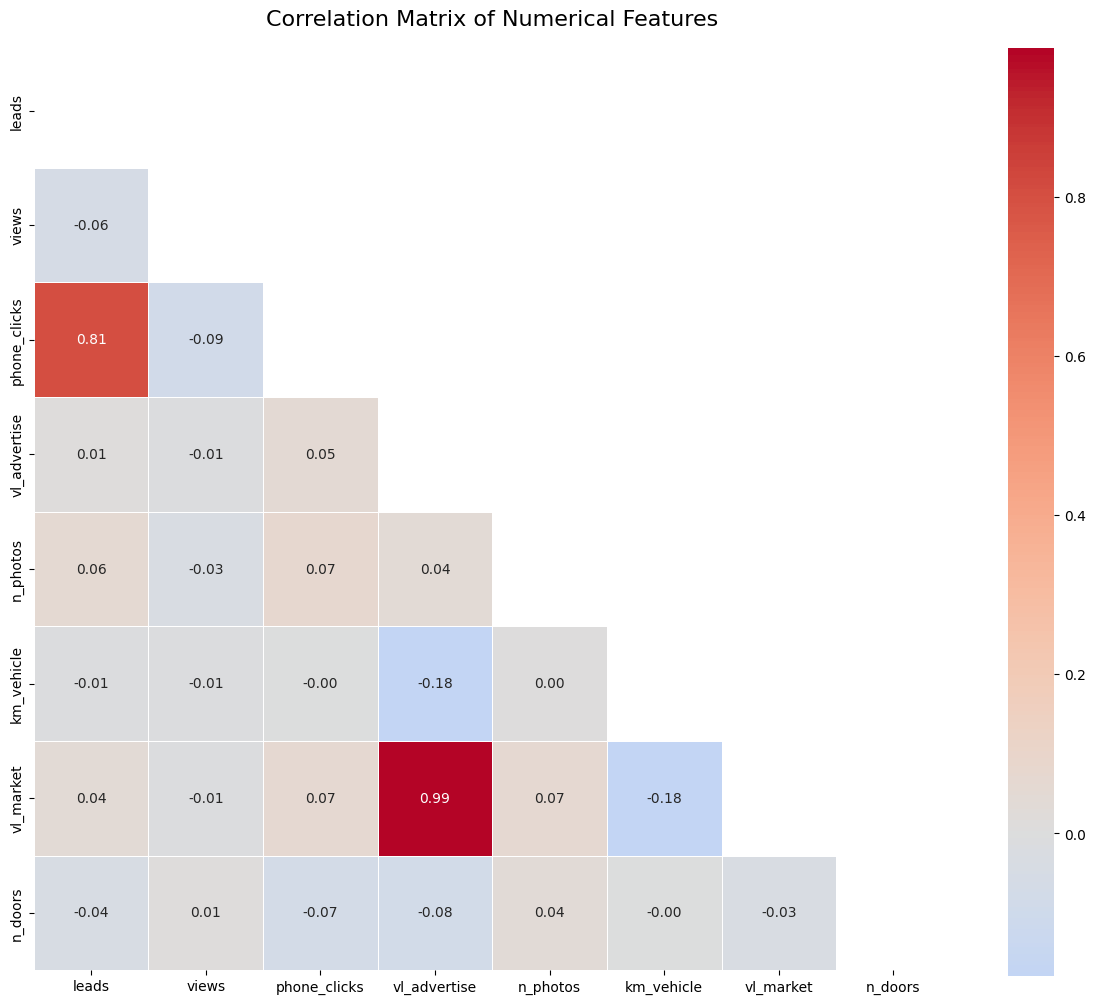


🎯 Correlations with 'leads' (sorted by absolute value):
  phone_clicks: 0.808
  views: -0.060
  n_photos: 0.059
  vl_market: 0.042
  n_doors: -0.041
  vl_advertise: 0.011
  km_vehicle: -0.009


In [4]:
# Convert all numerical columns to absolute values to handle any remaining negative values
for col in num_cols:
    df_clean[col] = df_clean[col].abs()

print("📈 Computing correlation matrix for numerical features...")

# Compute and display the correlation matrix
corr_matrix = df_clean[num_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Hide upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', 
            center=0, square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Focus on correlations with target variable
if 'leads' in num_cols:
    target_corr = corr_matrix['leads'].sort_values(key=abs, ascending=False)
    print(f"\n🎯 Correlations with 'leads' (sorted by absolute value):")
    for feature, corr in target_corr.items():
        if feature != 'leads':
            print(f"  {feature}: {corr:.3f}")

### Statistical Summary

In [5]:
def summarize_numerical_features(df, cols, target_col=None):
    """Create comprehensive summary of numerical features"""
    num_cols_clean = [col for col in cols if col != target_col]
    
    summary = df[num_cols_clean].describe().T
    summary['skew'] = df[num_cols_clean].skew()
    summary['missing_pct'] = df[num_cols_clean].isnull().mean() * 100
    
    if target_col and target_col in df.columns:
        summary['corr_with_target'] = df[num_cols_clean].corrwith(df[target_col])
        return summary.sort_values(by='corr_with_target', key=abs, ascending=False)
    else:
        return summary

numerical_summary = summarize_numerical_features(df_clean, cols=num_cols, target_col='leads')
print("📊 Numerical Features Summary (sorted by correlation with target):")
display(numerical_summary)

# Identify highly skewed features
high_skew = numerical_summary[abs(numerical_summary['skew']) > 2]
print(f"\n⚠️ Highly skewed features (|skew| > 2): {len(high_skew)}")
if len(high_skew) > 0:
    for feature in high_skew.index:
        skew_val = high_skew.loc[feature, 'skew']
        print(f"  - {feature}: {skew_val:.2f}")

📊 Numerical Features Summary (sorted by correlation with target):


,count,mean,std,min,25%,50%,75%,max,skew,missing_pct,corr_with_target
phone_clicks,48578.0,7.463687,11.452176,0.00000,2.000000,4.00000,9.00000,4.570000e+02,7.997183,0.000000,0.807507
views,48578.0,446.628144,1106.081286,0.00000,76.000000,196.00000,452.00000,9.360800e+04,31.907745,0.000000,-0.059993
n_photos,48578.0,6.626251,2.169288,0.00000,6.000000,8.00000,8.00000,2.000000e+01,-1.678539,0.000000,0.059259
vl_market,42403.0,52734.133217,41300.647472,6292.84354,31373.475855,40669.30355,61530.26244,9.212392e+05,4.615018,12.711516,0.041979
n_doors,48577.0,3.728019,0.821155,0.00000,4.000000,4.00000,4.00000,4.000000e+00,-3.196551,0.002059,-0.041443
vl_advertise,48578.0,55771.674588,51997.433711,0.00000,30490.000000,41000.00000,64590.00000,1.200000e+06,5.743068,0.000000,0.010719
km_vehicle,48578.0,68582.742867,88078.042323,0.00000,29000.000000,57000.00000,90000.00000,1.320000e+06,7.572634,0.000000,-0.009182



⚠️ Highly skewed features (|skew| > 2): 6
  - phone_clicks: 8.00
  - views: 31.91
  - vl_market: 4.62
  - n_doors: -3.20
  - vl_advertise: 5.74
  - km_vehicle: 7.57


### Distribution Analysis

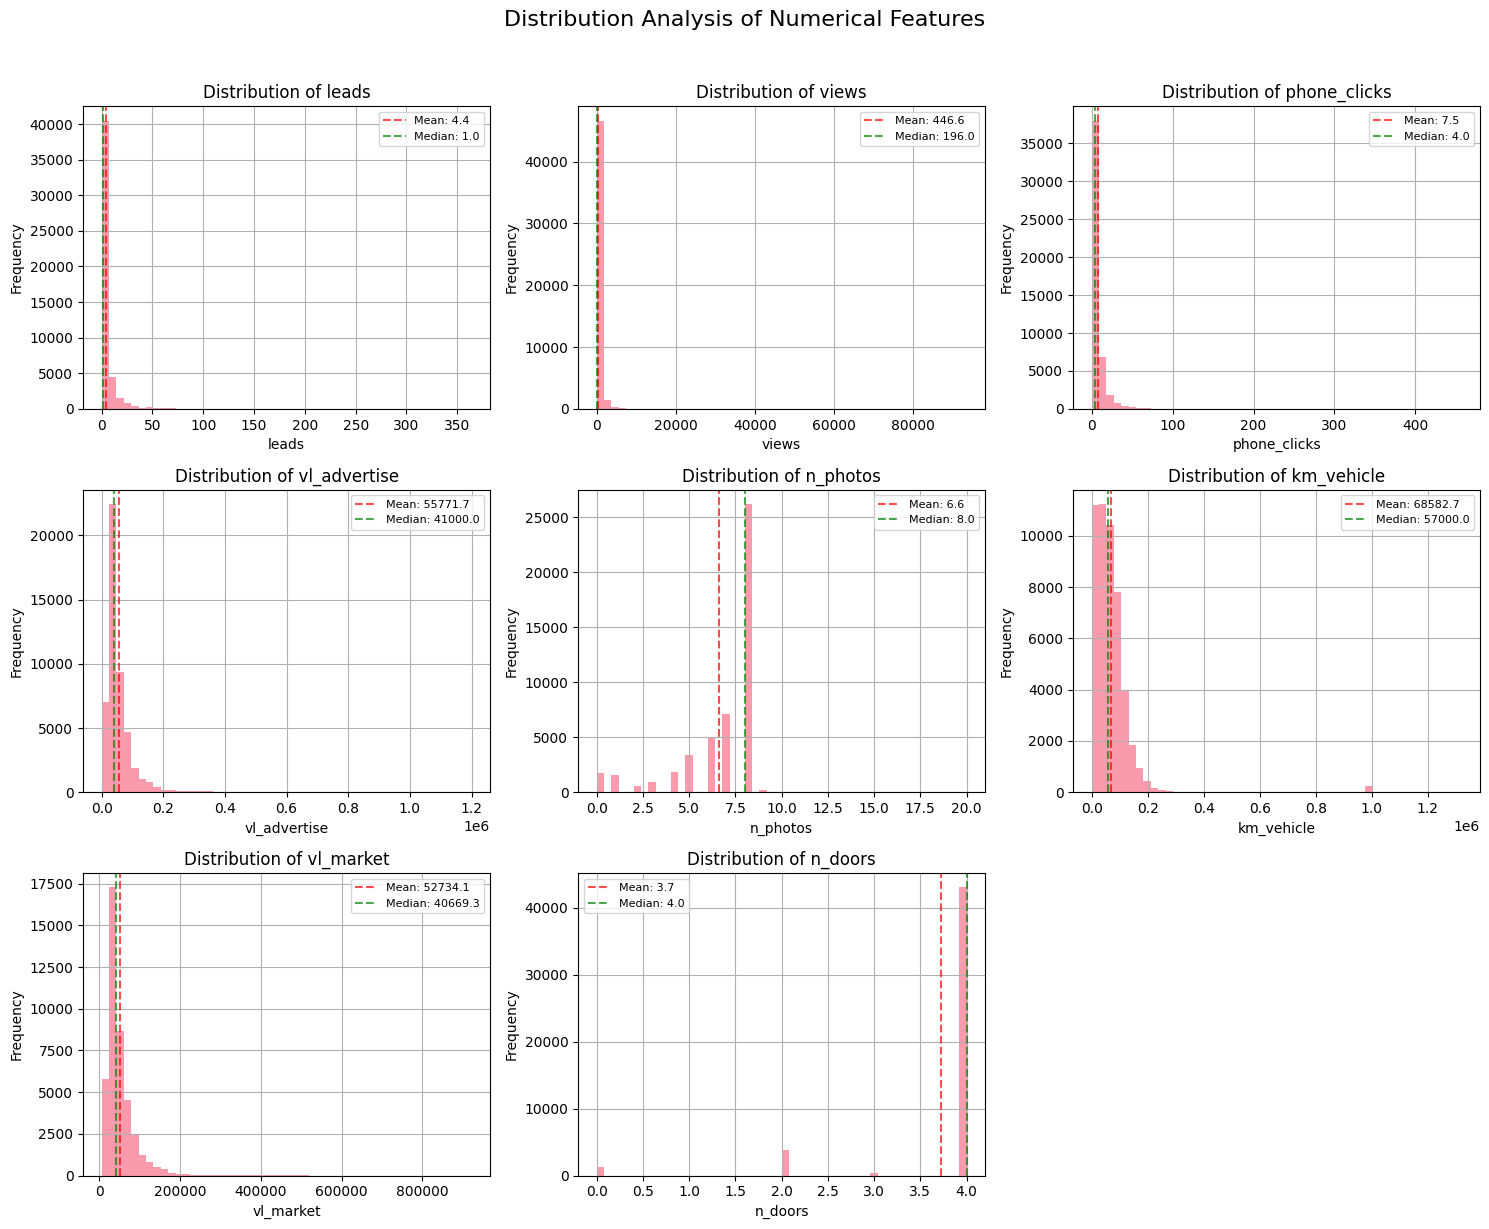

In [6]:
# Create KDE plots for all numerical features
n_features = len(num_cols)
n_cols_plot = 3
n_rows = (n_features + n_cols_plot - 1) // n_cols_plot

fig, axes = plt.subplots(n_rows, n_cols_plot, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for i, col in enumerate(num_cols):
    if i < len(axes):
        df_clean[col].hist(bins=50, ax=axes[i], alpha=0.7)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        
        # Add statistics text
        mean_val = df_clean[col].mean()
        median_val = df_clean[col].median()
        skew_val = df_clean[col].skew()
        axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.1f}')
        axes[i].axvline(median_val, color='green', linestyle='--', alpha=0.7, label=f'Median: {median_val:.1f}')
        axes[i].legend(fontsize=8)

# Hide extra subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Distribution Analysis of Numerical Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 📦 Outlier Analysis

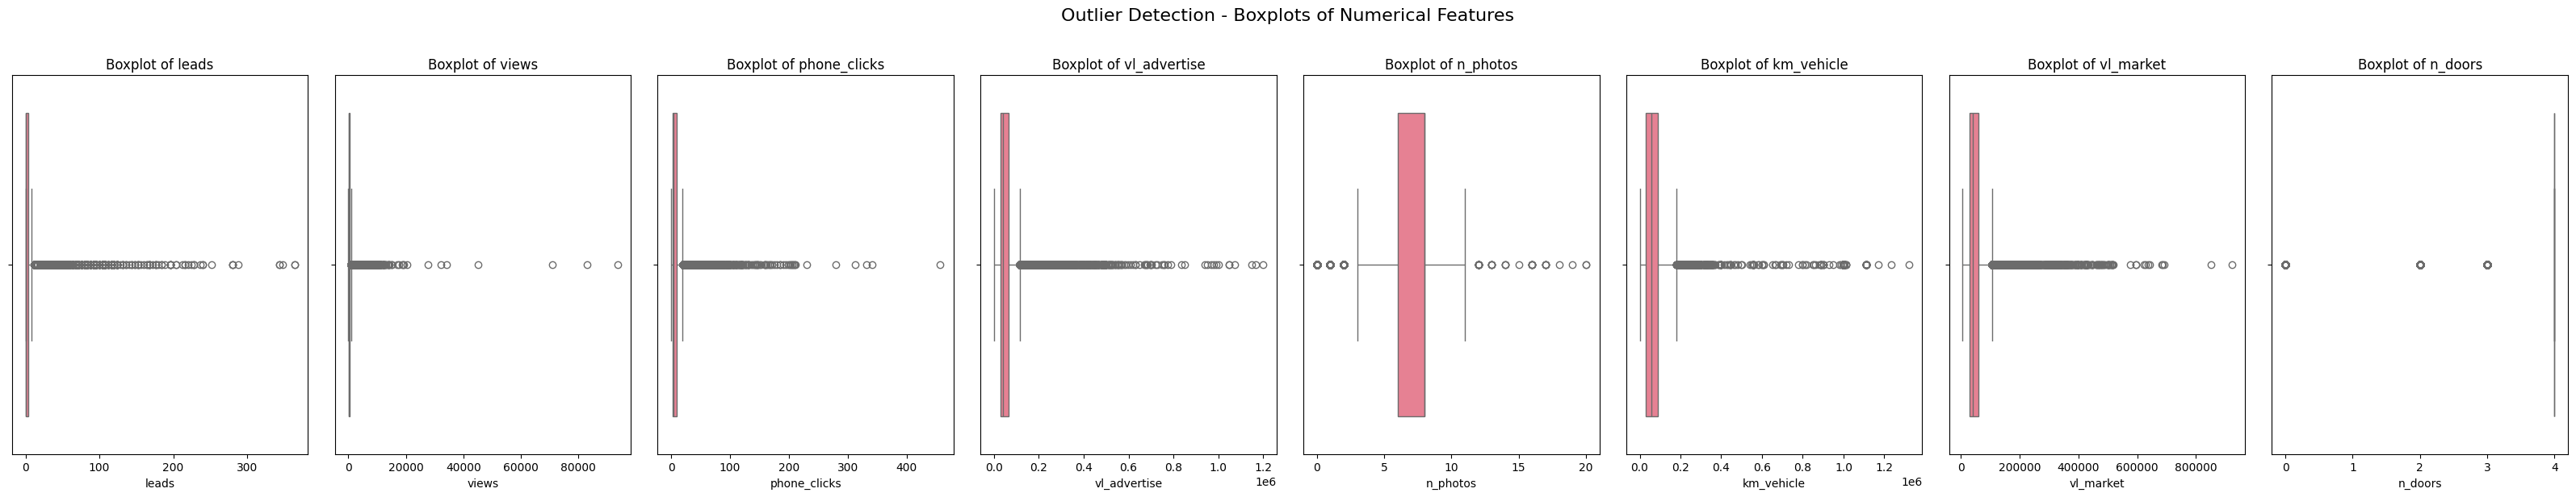

In [7]:
# Create box plots for outlier detection
n_features = len(num_cols)
fig, axes = plt.subplots(1, n_features, figsize=(4*n_features, 6))
if n_features == 1:
    axes = [axes]

for i, col in enumerate(num_cols):
    sns.boxplot(data=df_clean, x=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)

plt.suptitle('Outlier Detection - Boxplots of Numerical Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 🏷️ Categorical Features Analysis

### What do adversiments with more leads have in common? 

In [8]:
# Filter flags columns
flag_cols = [col for col in df_clean.columns if col.startswith('flg_')]

# Group by unique combinations of this columns 
grouped = (
    df_clean.groupby(flag_cols)
      .agg(
          n_ads=('leads', 'count'),
          mean_leads=('leads', 'mean'),
          sum_leads=('leads', 'sum')
      )
      .reset_index()
)

# Sorte by sum leads
grouped_sorted = grouped.sort_values(by='sum_leads', ascending=False)
grouped_sorted["proportion"] = (grouped_sorted["sum_leads"] / df_clean.leads.sum() )*100
grouped_sorted.head(10)


,flg_single_owner,flg_lincese,flg_tax_paid,flg_all_dealership_services,flg_all_dealership_schedule_vehicle,flg_factory_warranty,flg_armored,flg_trade_in,flg_pcd,flg_alarm,...,flg_alcool,flg_gasolina,flg_diesel,flg_eletrico,flg_benzina,flg_gas_natural,n_ads,mean_leads,sum_leads,proportion
15,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1666,2.644058,4405,2.052905
10,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,550,4.954545,2725,1.269958
6249,0,1,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,177,15.259887,2701,1.258773
2368,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,539,3.493506,1883,0.877553
6272,0,1,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,124,14.241935,1766,0.823026
2580,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,364,4.412088,1606,0.748460
6128,0,1,1,0,0,0,0,0,0,1,...,1,1,0,0,0,0,214,6.929907,1483,0.691137
779,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,711,2.060478,1465,0.682748
6251,0,1,1,0,0,0,0,0,0,1,...,1,1,0,0,0,0,155,8.148387,1263,0.588608
2587,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,241,5.165975,1245,0.580219


In [9]:
top_combos = grouped_sorted.head(20)

flag_cols = [col for col in top_combos.columns if col.startswith('flg_')]

flag_summary = top_combos[flag_cols].sum().sort_values(ascending=False)

flag_summary_pct = (top_combos[flag_cols].sum() / len(top_combos)).sort_values(ascending=False)

common_flags = pd.DataFrame({
    'count_1_in_top_10': flag_summary,
    'proportion_1_in_top_10': flag_summary_pct
})

common_flags.sort_values(by='proportion_1_in_top_10', ascending=False)


,count_1_in_top_10,proportion_1_in_top_10
flg_gasolina,20,1.00
flg_leads,20,1.00
flg_electric_locks,18,0.90
flg_air_conditioning,18,0.90
flg_electric_windows,18,0.90
flg_rear_defogger,16,0.80
flg_heater,16,0.80
flg_alarm,15,0.75
flg_airbag,15,0.75
flg_abs,15,0.75


In [10]:
# Define the flag columns by common flags
flag_cols = common_flags[common_flags['proportion_1_in_top_10'] >= 0.75].index.tolist()

In [11]:
flag_cols.remove('flg_leads')  # Remove target flag if present

In [12]:
# Group by unique combinations of this columns 
grouped = (
    df_clean.groupby(flag_cols)
      .agg(
          n_ads=('leads', 'count'),
          mean_leads=('leads', 'mean'),
          sum_leads=('leads', 'sum')
      )
      .reset_index()
)

# Sorte by sum leads
grouped_sorted = grouped.sort_values(by='sum_leads', ascending=False)
grouped_sorted["proportion"] = (grouped_sorted["sum_leads"] / df_clean.leads.sum() )*100
grouped_sorted.head(10)


,flg_gasolina,flg_electric_locks,flg_air_conditioning,flg_electric_windows,flg_rear_defogger,flg_heater,flg_alarm,flg_airbag,flg_abs,n_ads,mean_leads,sum_leads,proportion
397,1,1,1,1,1,1,1,1,1,13923,6.062271,84405,39.336080
154,1,0,0,0,0,0,0,0,0,3831,3.160271,12107,5.642343
393,1,1,1,1,1,1,0,1,1,2622,4.064836,10658,4.967051
381,1,1,1,1,0,1,1,1,1,1877,4.649441,8727,4.067128
394,1,1,1,1,1,1,1,0,0,1776,4.431306,7870,3.667732
396,1,1,1,1,1,1,1,1,0,1332,5.437688,7243,3.375525
389,1,1,1,1,1,0,1,1,1,1664,3.862981,6428,2.995703
153,0,1,1,1,1,1,1,1,1,915,6.593443,6033,2.811617
369,1,1,1,1,0,0,0,1,1,1785,2.149020,3836,1.787728
373,1,1,1,1,0,0,1,1,1,969,3.479876,3372,1.571486


In [13]:
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

threshold = df_clean["leads"].quantile(0.80)
df_top = df_clean[df_clean["leads"] >= threshold]

# flag_cols = [col for col in df_top.columns if col.startswith('flg_')]
df_flags = df_top[flag_cols].astype(bool)

frequent_itemsets = fpgrowth(df_flags, min_support=0.3, use_colnames=True)

frequent_itemsets = frequent_itemsets.sort_values(by="support", ascending=False)

display(frequent_itemsets.head(10))

,support,itemsets
0,0.921808,(flg_gasolina)
1,0.866073,(flg_electric_locks)
2,0.861075,(flg_air_conditioning)
3,0.859432,(flg_electric_windows)
13,0.838480,"(flg_electric_locks, flg_electric_windows)"
10,0.819035,"(flg_air_conditioning, flg_electric_locks)"
14,0.816090,"(flg_air_conditioning, flg_electric_windows)"
9,0.801643,"(flg_gasolina, flg_electric_locks)"
16,0.799178,"(flg_air_conditioning, flg_electric_locks, flg..."
11,0.795755,"(flg_gasolina, flg_air_conditioning)"


In [14]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.9)
rules = rules.sort_values(by="confidence", ascending=False)

display(rules[["antecedents", "consequents", "support", "confidence", "lift"]])

,antecedents,consequents,support,confidence,lift
2508,"(flg_heater, flg_airbag, flg_gasolina, flg_ele...",(flg_electric_locks),0.363026,0.993256,1.146850
2426,"(flg_heater, flg_gasolina, flg_electric_window...",(flg_electric_locks),0.372749,0.993249,1.146842
2566,"(flg_heater, flg_airbag, flg_gasolina, flg_air...",(flg_electric_locks),0.359329,0.993187,1.146770
2459,"(flg_heater, flg_gasolina, flg_air_conditionin...",(flg_electric_locks),0.368299,0.993168,1.146749
1897,"(flg_heater, flg_airbag, flg_air_conditioning,...",(flg_electric_windows),0.416775,0.993147,1.155586
...,...,...,...,...,...
1599,"(flg_heater, flg_air_conditioning, flg_airbag,...","(flg_gasolina, flg_electric_locks)",0.438822,0.900140,1.122869
1679,"(flg_heater, flg_electric_locks, flg_airbag, f...","(flg_gasolina, flg_air_conditioning, flg_elect...",0.434851,0.900085,1.193007
396,"(flg_gasolina, flg_abs)","(flg_air_conditioning, flg_electric_windows, f...",0.555632,0.900067,1.326486
1477,"(flg_heater, flg_airbag, flg_alarm)","(flg_gasolina, flg_electric_windows)",0.444437,0.900028,1.133279


### Categorical Feature Classification

In [15]:
def classify_categorical_features(
    df,
    cols,
    threshold_low=15,
    threshold_high=50,
    id_keywords=["id", "cd_", "code"],
):
    """Classify categorical features by cardinality and type"""
    result = []

    for col in cols:
        if df[col].dtype == "object" or df[col].nunique() < 1000:
            nunique = df[col].nunique()
            col_lower = col.lower()

            if nunique == 2:
                category_type = "binary"
            elif any(key in col_lower for key in id_keywords):
                category_type = "identity/high cardinality"
            elif nunique <= threshold_low:
                category_type = "nominal (low cardinality)"
            elif nunique <= threshold_high:
                category_type = "nominal (medium cardinality)"
            else:
                category_type = "nominal (high cardinality)"

            result.append(
                {
                    "feature": col,
                    "dtype": str(df[col].dtype),
                    "n_unique": nunique,
                    "category_type": category_type,
                    "most_common": df[col].value_counts().index[0],
                    "most_common_pct": df[col].value_counts(normalize=True).iloc[0] * 100
                }
            )

    return pd.DataFrame(result).sort_values(by="category_type")

print("🏷️ Categorical Feature Classification:")
cat_summary = classify_categorical_features(df_clean, cols=cat_cols)
display(cat_summary)

# Summary by category type
print("\n📊 Summary by Category Type:")
category_counts = cat_summary['category_type'].value_counts()
for cat_type, count in category_counts.items():
    print(f"  - {cat_type}: {count} features")

print("\n📊 Summary by Dominant Categories:")
category_counts = cat_summary[cat_summary['most_common_pct'] > 75.0]
display(category_counts)

🏷️ Categorical Feature Classification:


,feature,dtype,n_unique,category_type,most_common,most_common_pct
0,cd_type_individual,int64,2,binary,2,84.847050
19,flg_air_conditioning,int64,2,binary,1,84.742064
20,flg_abs,int64,2,binary,1,63.357899
21,flg_rear_defogger,int64,2,binary,1,63.040883
22,flg_electric_locks,int64,2,binary,1,84.527976
23,flg_electric_windows,int64,2,binary,1,83.994812
24,flg_alloy_wheels,int64,2,binary,1,55.068138
35,flg_gas_natural,int64,2,binary,0,99.355675
25,flg_rain_sensor,int64,2,binary,0,91.195603
29,flg_leads,int64,2,binary,1,78.156779



📊 Summary by Category Type:
  - binary: 29 features
  - nominal (high cardinality): 3 features
  - identity/high cardinality: 2 features
  - nominal (low cardinality): 2 features
  - nominal (medium cardinality): 1 features

📊 Summary by Dominant Categories:


,feature,dtype,n_unique,category_type,most_common,most_common_pct
0,cd_type_individual,int64,2,binary,2,84.847050
19,flg_air_conditioning,int64,2,binary,1,84.742064
22,flg_electric_locks,int64,2,binary,1,84.527976
23,flg_electric_windows,int64,2,binary,1,83.994812
35,flg_gas_natural,int64,2,binary,0,99.355675
25,flg_rain_sensor,int64,2,binary,0,91.195603
29,flg_leads,int64,2,binary,1,78.156779
31,flg_gasolina,int64,2,binary,1,94.149615
32,flg_diesel,int64,2,binary,0,94.489275
33,flg_eletrico,int64,2,binary,0,99.942361


In [16]:
category_counts.feature.values

array(['cd_type_individual', 'flg_air_conditioning', 'flg_electric_locks',
       'flg_electric_windows', 'flg_gas_natural', 'flg_rain_sensor',
       'flg_leads', 'flg_gasolina', 'flg_diesel', 'flg_eletrico',
       'flg_benzina', 'flg_pcd', 'flg_trade_in', 'flg_armored',
       'flg_factory_warranty', 'flg_all_dealership_schedule_vehicle',
       'flg_all_dealership_services', 'flg_single_owner', 'priority'],
      dtype=object)

## 🔗 Bivariate Analysis

### Categorical Features vs Target

In [17]:
cities = df_clean['city'].unique().tolist()
for i in cities:
    if "Paulo" in i:
        print(i)

São Paulo
Paulo Afonso
Paulo Lopes
S�o Paulo


In [18]:
# Do a fix we did not do before

df_clean['city'] = df_clean['city'].str.replace('S�o Paulo', 'São Paulo', regex=False)

In [19]:
df_clean[df_clean.city == "São Paulo"].leads.sum()

88629

In [20]:
cities = df_clean['city'].unique().tolist()
for i in cities:
    if "Paulo" in i:
        print(i)

São Paulo
Paulo Afonso
Paulo Lopes


In [21]:
# Bivariate analysis of categorical features with target
dfs_bivariate = {}

print("🔗 Computing bivariate analysis for categorical features...")

for col in cat_cols:
    if col != 'flg_leads':  # Skip the binary target
        grouped = (
            df_clean.groupby(col)['leads']
            .agg(
                count='count',
                mean_leads='mean',
                sum_leads='sum'
            )
            .sort_values(by='sum_leads', ascending=False)
            .reset_index()
        )
        grouped['percentage'] = (grouped['count'] / grouped['count'].sum()) * 100
        dfs_bivariate[col] = grouped

print(f"✅ Completed bivariate analysis for {len(dfs_bivariate)} categorical features")

🔗 Computing bivariate analysis for categorical features...
✅ Completed bivariate analysis for 39 categorical features


In [22]:
# Display top performing categories for non-ID features
print("📊 Top 10 Categories by Lead Performance (Non-ID Features):")

for feature_name in dfs_bivariate.keys():
    # Skip ID-like features for display
    if any(
        prefix in feature_name for prefix in ["cd_", "flg_"]
    ) and not feature_name.startswith("cd_type"):
        continue

    if feature_name in ["city", "state", "transmission_type", "priority"]:
        print(f"\n🎯 {feature_name.upper()}:")
        top_data = dfs_bivariate[feature_name].head(10)
        display(
            top_data[
                [
                    "state" if feature_name == "state" else feature_name,
                    "count",
                    "mean_leads",
                    "sum_leads",
                    "percentage",
                ]
            ]
            .sort_values(by="sum_leads", ascending=False)
            .head(10)
        )

📊 Top 10 Categories by Lead Performance (Non-ID Features):

🎯 TRANSMISSION_TYPE:


,transmission_type,count,mean_leads,sum_leads,percentage
0,automatico,20825,5.180024,107874,42.870083
1,manual,26970,3.714794,100188,55.520102
2,CVT,504,9.851190,4965,1.037528
3,automatizado,133,7.052632,938,0.273792
4,semi-automatico,123,2.837398,349,0.253206
5,automatizado DCT,11,19.000000,209,0.022644
6,automatico sequencial,11,4.545455,50,0.022644



🎯 CITY:


,city,count,mean_leads,sum_leads,percentage
0,São Paulo,9081,9.759828,88629,18.693647
1,Rio de Janeiro,2213,4.976051,11012,4.555560
2,Campinas,1273,5.818539,7407,2.620528
3,Belo Horizonte,1427,4.003504,5713,2.937544
4,São Bernardo do Campo,825,6.351515,5240,1.698300
5,Curitiba,2010,2.491045,5007,4.137675
6,Santo André,761,5.893561,4485,1.566553
7,Brasília,1749,2.454545,4293,3.600395
8,São José do Rio Preto,666,5.249249,3496,1.370991
9,Osasco,672,4.616071,3102,1.383342



🎯 STATE:


,state,count,mean_leads,sum_leads,percentage
0,SP,22877,6.605455,151113,47.097213
1,RJ,3713,4.084837,15167,7.644007
2,MG,3236,3.073857,9947,6.662000
3,PR,4431,2.173099,9629,9.122164
4,SC,3755,1.759254,6606,7.730473
5,RS,2599,1.861485,4838,5.350599
6,DF,1756,2.449317,4301,3.615103
7,GO,931,2.567132,2390,1.916663
8,BA,628,2.568471,1613,1.292873
9,PE,771,1.766537,1362,1.587269



🎯 PRIORITY:


,priority,count,mean_leads,sum_leads,percentage
0,3,37719,3.354861,126542,77.646260
1,1,8496,7.450800,63302,17.489398
2,2,2363,10.465510,24730,4.864342


### Visualization: Top Cities by Lead Performance

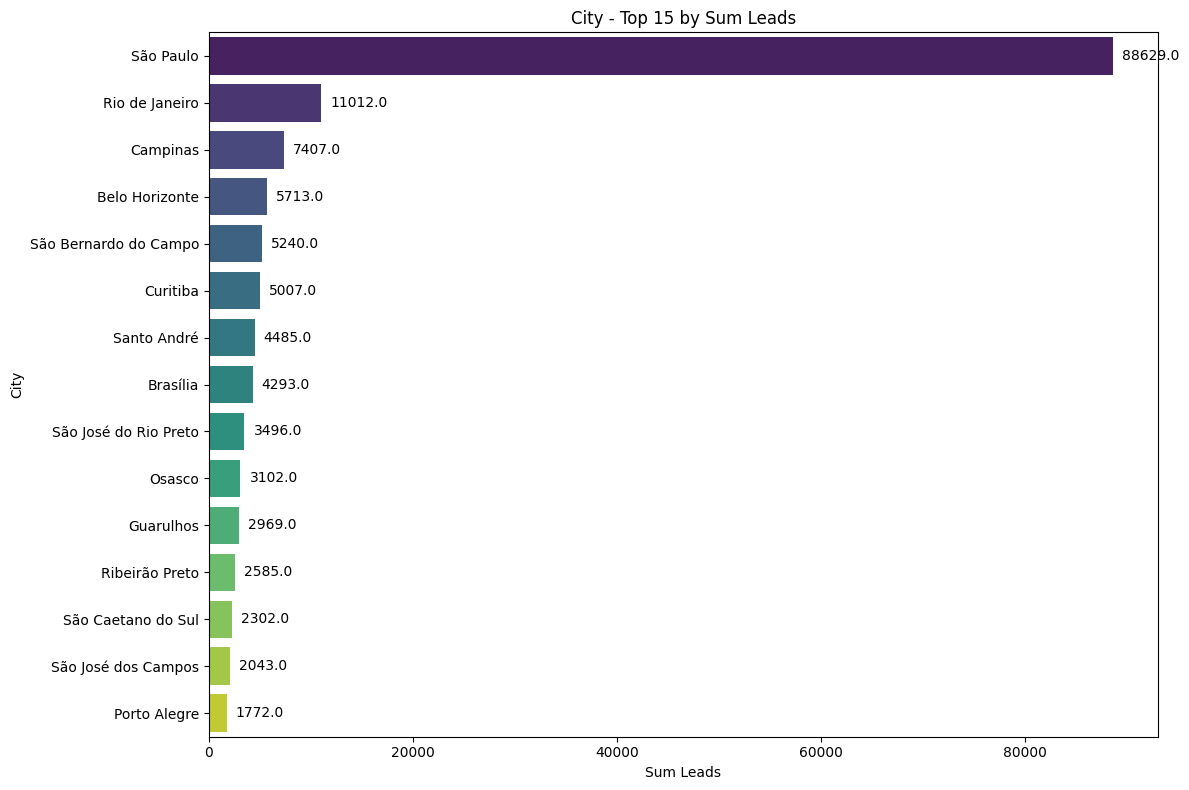

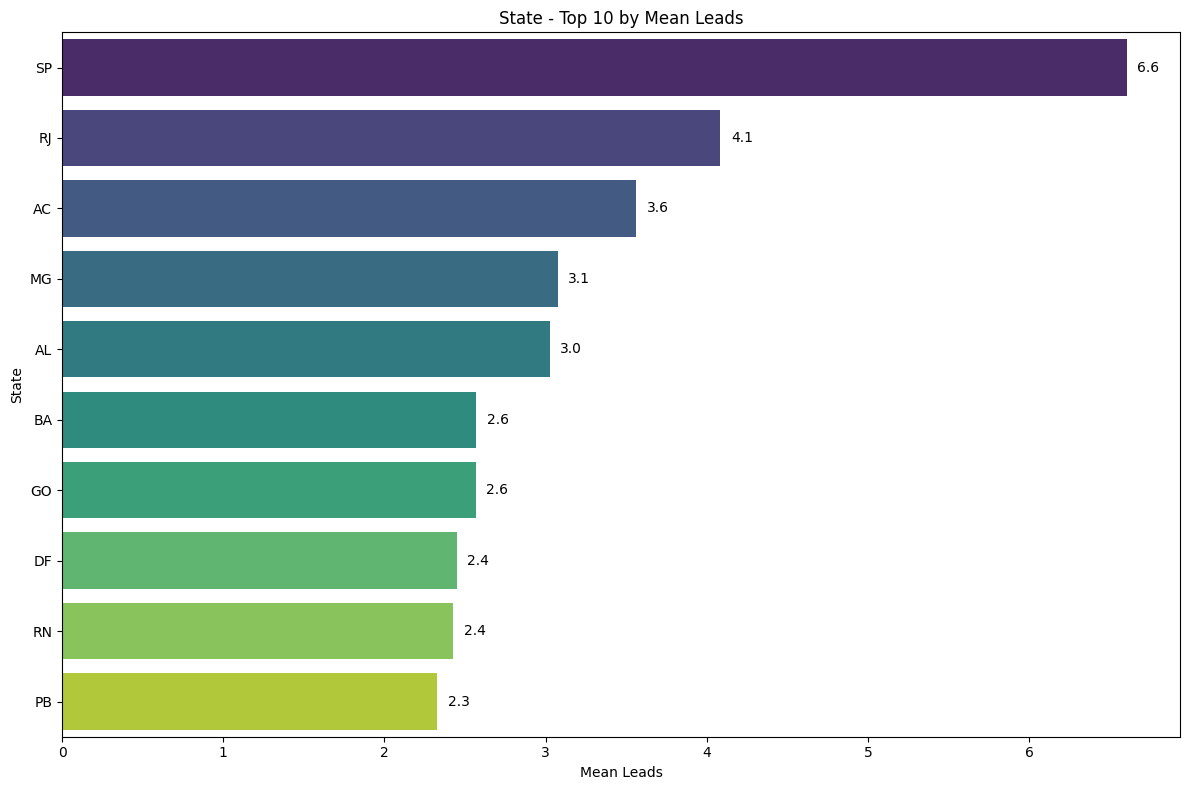

In [23]:
def plot_top_categories(feature_name, metric='sum_leads', top_n=10, figsize=(12, 8)):
    """Plot top categories for a given feature"""
    if feature_name not in dfs_bivariate:
        print(f"Feature '{feature_name}' not found in bivariate analysis")
        return
    
    df_plot = dfs_bivariate[feature_name].sort_values(by=metric, ascending=False).head(top_n)
    
    plt.figure(figsize=figsize)
    sns.barplot(data=df_plot, x=metric, y=feature_name, palette='viridis')
    plt.title(f'{feature_name.title()} - Top {top_n} by {metric.replace("_", " ").title()}')
    plt.xlabel(metric.replace("_", " ").title())
    plt.ylabel(feature_name.title())
    
    # Add value labels on bars
    ax = plt.gca()
    for i, v in enumerate(df_plot[metric]):
        ax.text(v + max(df_plot[metric]) * 0.01, i, f'{v:.1f}', 
                va='center', ha='left', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Plot top cities and states
if 'city' in dfs_bivariate:
    plot_top_categories('city', metric='sum_leads', top_n=15)

if 'state' in dfs_bivariate:
    plot_top_categories('state', metric='mean_leads', top_n=10)

### The number of leads are concetrated in newest car models? 

In [25]:
df_clean.groupby('year_model')['leads'].sum().sort_values(ascending=False).head(15)

year_model
2015    24519
2014    24077
2013    22216
2012    19514
2017    18153
2016    17301
2018    15642
2011    14853
2010    12210
2008     8542
2009     8112
2007     4635
2019     3984
2006     3820
2005     3404
Name: leads, dtype: int64

## 📊 Feature-Target Relationship Summary

In [ ]:
# Create a comprehensive feature importance summary
feature_insights = []

# Numerical features insights
print("📈 NUMERICAL FEATURES INSIGHTS:")
for feature in numerical_summary.index:
    corr = numerical_summary.loc[feature, 'corr_with_target']
    skew = numerical_summary.loc[feature, 'skew']
    
    insight = {
        'feature': feature,
        'type': 'numerical',
        'correlation': corr,
        'abs_correlation': abs(corr),
        'skewness': skew,
        'high_skew': abs(skew) > 2
    }
    feature_insights.append(insight)
    
    print(f"  {feature}: corr={corr:.3f}, skew={skew:.2f}")

# Categorical features insights
print(f"\n🏷️ CATEGORICAL FEATURES INSIGHTS:")
for _, row in cat_summary.iterrows():
    feature = row['feature']
    if feature in dfs_bivariate:
        # Calculate range of mean leads across categories
        mean_leads_range = dfs_bivariate[feature]['mean_leads'].max() - dfs_bivariate[feature]['mean_leads'].min()
        top_category_pct = dfs_bivariate[feature]['percentage'].max()
        
        insight = {
            'feature': feature,
            'type': 'categorical',
            'category_type': row['category_type'],
            'n_unique': row['n_unique'],
            'mean_leads_range': mean_leads_range,
            'top_category_dominance': top_category_pct
        }
        feature_insights.append(insight)
        
        print(f"  {feature}: {row['category_type']}, range={mean_leads_range:.2f}, dominance={top_category_pct:.1f}%")

# Convert to DataFrame for easier analysis
insights_df = pd.DataFrame(feature_insights)
print(f"\n✅ Generated insights for {len(insights_df)} features")

### Clients with more ads, receive more leads?

In [ ]:
client_stats = (
    df_clean.groupby('cd_client')
      .agg(
          n_ads=('leads', 'count'),
          total_leads=('leads', 'sum'),
          avg_leads_per_ad=('leads', 'mean')
      )
      .reset_index()
)


sns.scatterplot(data=client_stats, x='n_ads', y='total_leads')
plt.title("Do clients with more ads get more leads?")
plt.xlabel("Number of Ads per Client")
plt.ylabel("Total Leads")
plt.show()

In [ ]:
correlation = client_stats[['n_ads', 'total_leads']].corr().iloc[0, 1]
print(f"Correlation between number of ads and total leads: {correlation:.2f}")


### Advertises with vl_market (market value) lower then vl_advertise (advertise value) have less leads? 

In [ ]:
df_clean['price_diff'] = df_clean['vl_advertise'] - df_clean['vl_market']
df_clean['price_ratio'] = df_clean['vl_advertise'] / df_clean['vl_market']

df_clean['above_market'] = (df_clean['vl_advertise'] > df_clean['vl_market']).astype(int)


sns.scatterplot(data=df_clean, x='price_ratio', y='leads', alpha=0.3)
plt.axvline(1.0, color='red', linestyle='--')
plt.title("Leads vs. Price Ratio (Advertised / Market)")
plt.xlabel("Price Ratio")
plt.ylabel("Leads")
plt.show()


In [ ]:
df_clean.groupby('above_market')['leads'].agg(['count', 'mean', 'median', 'sum'])


In [ ]:
output_path = '../../data/processed/cleaned_data.csv'
print(f"💾 Saving cleaned dataset to: {output_path}")

try:
    save_processed_data(df_clean, output_path)
    print(f"✅ Successfully saved cleaned dataset")
    print(f"📊 Saved shape: {df_clean.shape}")
except Exception as e:
    print(f"❌ Error saving dataset: {e}")
    # Alternative save method
    df_clean.to_csv(output_path, index=False)
    print(f"✅ Saved using alternative method")